In [1]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A4000 (UUID: GPU-7717749d-7eb0-4ce7-704e-2c6e57f54d5a)
GPU 1: NVIDIA RTX A4000 (UUID: GPU-9413fe21-1167-c68e-f63b-71efd4da0dd2)
GPU 2: NVIDIA RTX A4000 (UUID: GPU-ee364761-a1a1-90d4-d422-6670335c0846)
GPU 3: NVIDIA RTX A4000 (UUID: GPU-764b05fb-a8ca-cc5f-68a3-a28526803f66)
GPU 4: NVIDIA RTX A4000 (UUID: GPU-7dd2f9fe-a16d-08b3-48de-d93ef560e886)
GPU 5: NVIDIA RTX A4000 (UUID: GPU-e795136e-b448-ed30-009e-7e16cd245cf7)
GPU 6: NVIDIA RTX A4000 (UUID: GPU-c8a8662f-2697-fd00-09ff-f0e01a75e65b)
GPU 7: NVIDIA RTX A4000 (UUID: GPU-865c3d64-c6eb-f368-c392-047fd2bd90e2)


In [2]:
!which python

/home/josephmiller/miniconda3/envs/perspective_point/bin/python


(Only works on Google Colab) Ensure torch and torchvision are installed. If pytorch3d is not installed, install it using the following cell: (Source: https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh)

In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

/home/josephmiller/miniconda3/envs/perspective_point/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor, Resize, CenterCrop, Normalize, Compose
import torchvision.models as models

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVOrthographicCameras, 
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    RasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# from torchvision.models import efficientnet, EfficientNet_V2_M_Weights
from torch.nn.functional import cosine_similarity
from PIL import Image
from img2vec import Img2Vec
import pandas as pd

In [5]:
IMAGE_SIZE = 224
# Load the pretrained model
img_model = models.resnet18(pretrained=True).to(device)
# Use the model object to select the desired layer
layer = img_model._modules.get('avgpool')
# Set model to evaluation mode
img_model.eval()

transforms_pil = Compose([
    Resize(IMAGE_SIZE),
    # CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transforms_tensor = Compose([
    Resize(IMAGE_SIZE),
    # CenterCrop(224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def get_vector(image):
    # Create a PyTorch tensor with the transformed image
    if(torch.is_tensor(image)):
        t_img = transforms_tensor(image)
    else:
        t_img = transforms_pil(image).to(device)
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512).to(device)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    # with torch.no_grad():
    img_model(t_img.unsqueeze(0))
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


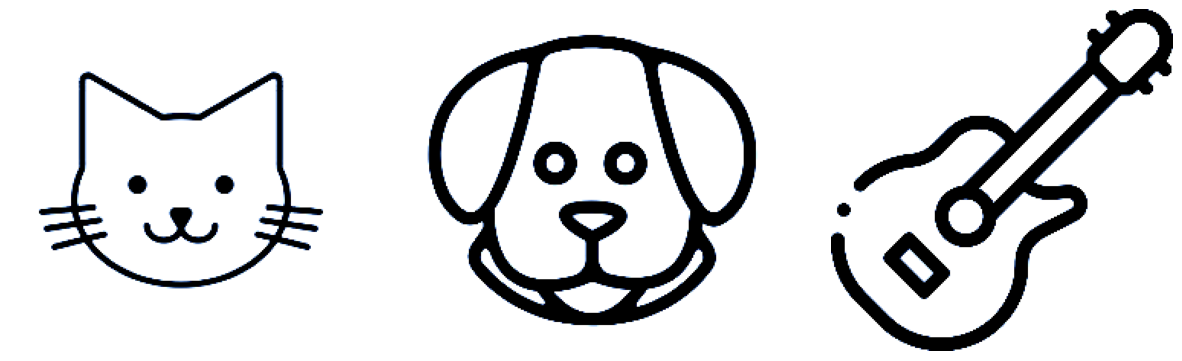

In [6]:
img2vec = Img2Vec(cuda=True)

transform_to_tensor = ToTensor()
resize_transform = Resize(IMAGE_SIZE)
# Read in an image (rgb format)
# img = Image.open('cat_face_line_drawing.jpeg')
# img_arr = ['cat_face_line_drawing.jpeg', 'guitar.jpeg', 'The-Triskele.jpeg']
img_arr = ['cat_face_line_drawing.jpeg', 'dog_face.jpeg', 'guitar.jpeg']
# if img.mode != 'RGB':
#     img = img.convert('RGB')
# tensor_img = transform_to_tensor(img)
# print('tensor_image.shape', tensor_img.shape)
# # cat_vec = img2vec.get_vec(img, tensor=True).requires_grad_(True)
# img_vec = get_vector(img).clone().detach().to(device)
# print('cat_vec', cat_vec)
img_tensors = []
for img_name in img_arr:
    img = Image.open(f'images/{img_name}')
    img_tensor = transforms_pil(img).permute(1, 2, 0).unsqueeze(0).to(device).requires_grad_(True)
    img_tensors.append(img_tensor)
img_tensor = torch.cat(img_tensors, dim=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for axs, image in zip(axs, img_tensor):
    img = image[..., :3].clone().detach().cpu().numpy()
    axs.imshow(img)
    axs.axis("off")

pairwise_dist.shape torch.Size([500, 500]) tensor([[ 0.0000,  9.1760,  4.8686,  6.8607,  9.0121],
        [ 9.1760,  0.0000,  9.2462,  6.6716,  8.5543],
        [ 4.8686,  9.2462,  0.0000,  2.5746, 11.2629],
        [ 6.8607,  6.6716,  2.5746,  0.0000,  9.8485],
        [ 9.0121,  8.5543, 11.2629,  9.8485,  0.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
nearest_neighbors torch.Size([500, 30]) tensor([[0.0000, 0.9023, 0.9376, 1.0013, 1.0324],
        [0.0000, 0.9101, 1.0337, 1.1383, 1.4046],
        [0.0000, 0.8575, 1.0988, 1.1560, 1.4243],
        [0.0000, 0.9486, 1.3415, 1.4809, 1.5355],
        [0.0000, 0.6975, 1.2296, 1.4351, 1.4929]], device='cuda:0',
       grad_fn=<SliceBackward0>)
near_neighbors_avg_dist torch.Size([500]) tensor([1.9708, 2.3352, 2.1718, 2.4767, 2.2083], device='cuda:0',
       grad_fn=<SliceBackward0>)
avg_near_neighbors_dist torch.Size([]) 0.24637198448181152
image diff -19.174686431884766 avg dist from origin 3.8038976192474365 avg near neighbors 

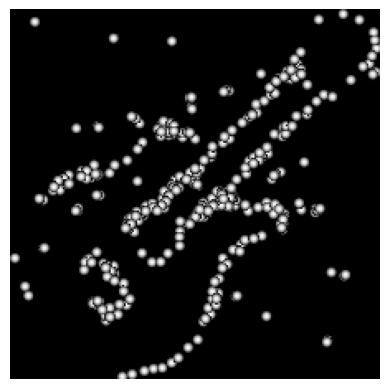

In [11]:
num_points = 500 
init_size = 8 
verts = (torch.rand(num_points, 3) * init_size) - (init_size/2)
rgb = torch.ones(num_points, 3).to(device)

class Model(torch.nn.Module):
    def __init__(self, verts, rgb):
        super().__init__()
        camera_poses = torch.Tensor([[10, 0, 0], [0, 10, 0]])
        R, T = look_at_view_transform(eye=camera_poses, at=((0, 0, 0), ), up=((0, 0, 1), ))
        R_vert, T_vert = look_at_view_transform(eye=torch.Tensor([[0, 0, 10]]), at=((0, 0, 0), ), up=((1, 0, 0), ))
        R, T = torch.cat([R, R_vert], dim=0), torch.cat([T, T_vert], dim=0)
        # cameras = FoVOrthographicCameras(device=device, R=R, znear=0.01)
        cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.1, fov=60)
        raster_settings = PointsRasterizationSettings(image_size=IMAGE_SIZE, radius = 0.03, points_per_pixel = 1)
        rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
        self.renderer = PointsRenderer( rasterizer=rasterizer, compositor=AlphaCompositor()) # with AlphaCompositor nearer points are weighted more
        self.verts = torch.nn.Parameter(verts, requires_grad=True)
        # self.rgb = torch.nn.Parameter(rgb, requires_grad=True)
        self.rgb = rgb.to(device)
        
    def forward(self, i, print_every=100):
        show = i % print_every == 0
        point_cloud = Pointclouds(points=self.verts.repeat(len(img_arr), 1, 1), features=self.rgb.repeat(len(img_arr), 1, 1))
        images = self.renderer(point_cloud)

        avg_dist_from_origin = torch.linalg.norm(self.verts, dim=1, ord=2).mean()
        # avg_dist_loss = torch.mean(total_dist)

        pairwise_dist = torch.cdist(self.verts, self.verts, p=1) #, compute_mode='use_mm_for_euclid_dist')
        show and print('pairwise_dist.shape', pairwise_dist.shape, pairwise_dist[:5, :5])
        # Get the 10 nearest neighbors for each point
        nearest_neighbors = pairwise_dist.topk(30, dim=1, largest=False, sorted=True)[0]
        show and print('nearest_neighbors', nearest_neighbors.shape, nearest_neighbors[:5, :5])
        EXCLUDE_CLOSEST_N = 3
        # Remove the EXCLUDE_CLOSEST_N closest neighbors (the point itself and its two closest neighbors) and take the mean
        near_neighbors_avg_dist = nearest_neighbors[:, EXCLUDE_CLOSEST_N:].mean(dim=1)
        show and print('near_neighbors_avg_dist', near_neighbors_avg_dist.shape, near_neighbors_avg_dist[:5])
        avg_near_neighbors_dist = near_neighbors_avg_dist.nanmean() * 0.1
        show and print('avg_near_neighbors_dist', avg_near_neighbors_dist.shape, avg_near_neighbors_dist.item())

        # min_pairwise_dist = pairwise_dist.min()
        # print('min_pairwise_dist', min_pairwise_dist.shape, min_pairwise_dist)
        # avg_min_pairwise_dist = min_pairwise_dist.mean()
        # print('avg_min_pairwise_dist', avg_min_pairwise_dist.shape, avg_min_pairwise_dist)
        # avg_pairwise_dist = torch.mean(pairwise_dist)
        
        if True or i < 0:
            image_diff = -torch.abs(images - img_tensor).sum() / 50000
            # print('loss 1', loss.item())
        else:
            # vec = img2vec.get_vec(transform(images[0].permute(2, 0, 1)), tensor=True).requires_grad_(True)
            vec = get_vector(images[0].permute(2, 0, 1)).requires_grad_(True)
            loss = cosine_similarity(img_vec, vec, dim=0)

        loss = image_diff - avg_near_neighbors_dist
        show and print('image diff', image_diff.item(), 'avg dist from origin', avg_dist_from_origin.item(), 'avg near neighbors dist', avg_near_neighbors_dist.item(), 'total loss', loss.item())

        return loss, images, self.verts

model = Model(verts=verts, rgb=rgb).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

print_every = 500

for i in range(5000 + 1):
    loss, images, _ = model(i, print_every)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_every == 0:
        print('i:', i, 'loss', loss.item())
        # 3 subplots
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # for axs, image in zip(axs, images):
        for image in images:
            img = image[..., :3].clone().detach().cpu().numpy()
            plt.imshow(img)
            plt.axis("off")

In [8]:
with torch.no_grad():
    _, _, final_verts = model(0) 
filtered_verts = final_verts[~torch.any(final_verts.isnan(),dim=1)]
verts_np = filtered_verts.clone().detach().cpu().numpy() #convert to Numpy array
df = pd.DataFrame(data=verts_np, columns=['x', 'y', 'z']) #convert to a dataframe
df.to_csv("verts.csv",index=False) 

pairwise_dist.shape torch.Size([500, 500]) tensor([[ 0.0000,  9.1611, 31.2449,  8.0760, 19.9359],
        [ 9.1611,  0.0000, 33.6982,  9.3534, 22.3892],
        [31.2449, 33.6982,  0.0000, 26.0962, 20.3039],
        [ 8.0760,  9.3534, 26.0962,  0.0000, 14.7872],
        [19.9359, 22.3892, 20.3039, 14.7872,  0.0000]], device='cuda:0')
nearest_neighbors torch.Size([500, 30]) tensor([[0.0000, 1.5443, 2.1793, 2.7414, 2.9378],
        [0.0000, 0.3555, 1.3623, 1.5833, 1.8685],
        [0.0000, 6.6010, 6.6094, 8.5701, 8.9674],
        [0.0000, 1.5290, 2.7024, 3.0197, 3.0236],
        [0.0000, 4.7166, 5.0332, 5.0673, 5.2633]], device='cuda:0')
near_neighbors_avg_dist torch.Size([500]) tensor([ 4.0073,  3.5247, 16.2760,  3.8250,  8.0535], device='cuda:0')
avg_near_neighbors_dist torch.Size([]) 1.7050306797027588
image diff -20.23036003112793 avg dist from origin nan avg near neighbors dist 1.7050306797027588 total loss -21.93539047241211


In [9]:
renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")

NameError: name 'cameras' is not defined